<a href="https://colab.research.google.com/github/mount24/landslide_prediction_using_satellite_images_by_applying_deep_lerning_method/blob/main/work2_test_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install h5py numpy torch segmentation_models_pytorch scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.1 MB/s eta 0:00:00


In [ ]:
# input_processing.py
# Load and preprocess MintPy outputs into georeferenced GeoTIFFs
import h5py
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Paths to MintPy HDF5 files
timeseries_file = '/content/drive/MyDrive/mintpy_output/location4/timeseries_ERA5_demErr.h5'
velocity_file   = '/content/drive/MyDrive/mintpy_output/location4/velocity.h5'
coherence_file  = '/content/drive/MyDrive/mintpy_output/location4/temporalCoherence.h5'
geom_file       = '/content/drive/MyDrive/mintpy_output/location4/geometryGeo.h5'

# Read time-series displacement (meters)
with h5py.File(timeseries_file, 'r') as f_ts:
    dates       = f_ts['date'][:]
    disp_stack  = f_ts['timeseries'][:]

# Read velocity (m/year)
with h5py.File(velocity_file, 'r') as f_vel:
    vel = f_vel['velocity'][:]

# Read temporal coherence (0–1)
with h5py.File(coherence_file, 'r') as f_coh:
    coherence = f_coh['temporalCoherence'][:]

# Read DEM and geolocation attributes
with h5py.File(geom_file, 'r') as f_geom:
    dem = f_geom['height'][:]
    # Coordinates from attributes (cast to float)
    x_first = float(f_geom.attrs['X_FIRST'])
    y_first = float(f_geom.attrs['Y_FIRST'])
    x_step  = float(f_geom.attrs['X_STEP'])
    y_step  = float(f_geom.attrs['Y_STEP'])
    epsg    = f_geom.attrs.get('EPSG', 4326)

# Create affine transform (pixel size: x_step, abs(y_step))
transform = from_origin(x_first, y_first, x_step, abs(y_step))

# Select roughly 12-day intervals (every other acquisition)
disp_selected = disp_stack[::2]  # shape: (T, H, W)
selected_dates = dates[::2]

# Normalize: 0.05 m (5 cm) → unit 1
disp_norm = disp_selected / 0.05
vel_norm  = vel / 0.05

# Compute slope magnitude from DEM
gy, gx = np.gradient(dem.astype(np.float32))
slope = np.sqrt(gx**2 + gy**2)

# Output dimensions
T, H, W = disp_norm.shape

# Write per-time-step GeoTIFFs (bands: displacement, coherence, slope)
for i in range(T):
    disp_i = disp_norm[i].astype(np.float32)
    coh_i  = coherence.astype(np.float32)
    slp_i  = slope.astype(np.float32)
    stack = np.stack([disp_i, coh_i, slp_i], axis=0)

    profile = {
        'driver': 'GTiff',
        'height': H,
        'width': W,
        'count': 3,
        'dtype': 'float32',
        'crs': f'EPSG:{int(epsg)}',
        'transform': transform
    }
    with rasterio.open(f'disp_step_{i:02d}.tif', 'w', **profile) as dst:
        dst.write(stack)

# Save velocity, coherence, and slope as single-band TIFFs
for arr, name in [(vel_norm, 'velocity_norm'), (coherence, 'coherence'), (slope, 'slope')]:
    profile = {
        'driver': 'GTiff',
        'height': H,
        'width': W,
        'count': 1,
        'dtype': 'float32',
        'crs': f'EPSG:{int(epsg)}',
        'transform': transform
    }
    with rasterio.open(f'{name}.tif', 'w', **profile) as dst:
        dst.write(arr.astype(np.float32), 1)

In [ ]:
# label_generation.py
# Generate 3-class landslide labels from normalized velocity and coherence

import numpy as np
import rasterio
from scipy.ndimage import label as cc_label

# File paths
velocity_tif = 'velocity_norm.tif'
coherence_tif = 'coherence.tif'

# Thresholds (normalized units: 1==5cm/yr)
stable_thr = 0.01 / 0.05  # 0.2 -> <1cm/yr
rapid_thr  = 0.05 / 0.05  # 1.0 -> >5cm/yr

# Connected component minimum size (400m extent / pixel size ~ 30m -> ~400/30≈13 pixels)
min_pixels = 13

# Read velocity and coherence
def read_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1)
        profile = src.profile
    return arr, profile

vel, profile = read_raster(velocity_tif)
coh, _       = read_raster(coherence_tif)

# Initialize label mask: 0=stable,1=moderate,2=rapid
labels = np.zeros_like(vel, dtype=np.uint8)

# Identify rapid pixels
rapid_mask = vel >= rapid_thr

# Connected components among rapid pixels
labeled, num = cc_label(rapid_mask)
for comp in range(1, num+1):
    comp_idx = (labeled == comp)
    if comp_idx.sum() >= min_pixels:
        labels[comp_idx] = 2

# Moderate: between stable_thr and rapid_thr OR isolated rapid pixels
mod_mask = ((vel >= stable_thr) & (vel < rapid_thr)) | ((vel >= rapid_thr) & (labels == 0))
labels[mod_mask] = 1

# Stable remains 0

# Optionally mask low-coh areas as stable (or no-data)
labels[coh < 0.7] = 0

# Save label GeoTIFF
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')
with rasterio.open('landslide_labels.tif', 'w', **profile) as dst:
    dst.write(labels, 1)

In [ ]:

# label_stack_generation.py
# Generate per-date 3-class label masks from displacement time series

import numpy as np
import h5py
import rasterio
from rasterio.transform import from_origin
from scipy.ndimage import label as cc_label
from datetime import datetime

# Paths
timeseries_file = '/content/drive/MyDrive/mintpy_output/location4/timeseries_ERA5_demErr.h5'
disp_dir = '/content'  # same folder where disp_step_*.tif were written

#/content/disp_step_00.tif
# Thresholds
stable_vel = 0.01   # m/yr threshold for stable (<1cm/yr)
rapid_vel  = 0.05   # m/yr threshold for rapid (>5cm/yr)
min_pixels = 13     # minimum spatial cluster

# Read displacement time series (meters)
with h5py.File(timeseries_file, 'r') as f:
    dates = [d.decode('utf-8') for d in f['date'][:]]           # list of 'YYYYMMDD'
    disp_stack = f['timeseries'][:]                             # shape (N, H, W)

# Subsample every 2 steps for ~12 days interval
sel_idx = list(range(0, disp_stack.shape[0], 2))
selected_dates = [dates[i] for i in sel_idx]
disp_sel = disp_stack[sel_idx]  # shape (T, H, W)

# Compute per-interval velocity (m/yr)
T, H, W = disp_sel.shape
vel_per_step = np.zeros((T, H, W), dtype=np.float32)
# Calculate days between dates
date_objs = [datetime.strptime(d, '%Y%m%d') for d in selected_dates]
for t in range(1, T):
    delta_disp = disp_sel[t] - disp_sel[t-1]           # meters over interval
    dt_days = (date_objs[t] - date_objs[t-1]).days
    m_per_yr = (delta_disp / dt_days) * 365.0
    vel_per_step[t] = m_per_yr
# First step label as stable
vel_per_step[0] = 0.0

# Read raster profile from first disp_step_00.tif
disp_tif = f'{disp_dir}/disp_step_00.tif'
with rasterio.open(disp_tif) as src:
    profile = src.profile.copy()
    transform = src.transform
    crs = src.crs

# Function to create label mask for one velocity frame
def make_label(vel_map, coh_map):
    labels = np.zeros_like(vel_map, dtype=np.uint8)
    # rapid mask
    rapid = vel_map >= rapid_vel
    lab, num = cc_label(rapid)
    for comp in range(1, num+1):
        comp_idx = (lab == comp)
        if comp_idx.sum() >= min_pixels:
            labels[comp_idx] = 2
    # moderate: between stable and rapid OR isolated rapid
    moderate = ((vel_map >= stable_vel) & (vel_map < rapid_vel)) | ((vel_map >= rapid_vel) & (labels == 0))
    labels[moderate] = 1
    # mask by coherence if desired
    # assume coherence static loaded earlier
    labels[coh_map < 0.7] = 0
    return labels

# Load coherence (static) for masking
coh_file = '/content/drive/MyDrive/mintpy_output/location4/temporalCoherence.h5'
with h5py.File(coh_file, 'r') as f:
    coherence = f['temporalCoherence'][:]

# Generate and save per-step labels
for t in range(T):
    lbl = make_label(vel_per_step[t], coherence)
    out_name = f'label_step_{t:02d}.tif'
    out_prof = profile.copy()
    out_prof.update(count=1, dtype=rasterio.uint8)
    with rasterio.open(out_name, 'w', **out_prof) as dst:
        dst.write(lbl, 1)
    print(f"Written {out_name} for date {selected_dates[t]}")

Written label_step_00.tif for date 20230707
Written label_step_01.tif for date 20230731
Written label_step_02.tif for date 20230824
Written label_step_03.tif for date 20230917
Written label_step_04.tif for date 20231023
Written label_step_05.tif for date 20231116
Written label_step_06.tif for date 20240208
Written label_step_07.tif for date 20240315
Written label_step_08.tif for date 20240408
Written label_step_09.tif for date 20240502
Written label_step_10.tif for date 20240526
Written label_step_11.tif for date 20240619
Written label_step_12.tif for date 20240713
Written label_step_13.tif for date 20240806
Written label_step_14.tif for date 20240830
Written label_step_15.tif for date 20240923
Written label_step_16.tif for date 20241029
Written label_step_17.tif for date 20241122
Written label_step_18.tif for date 20241216


In [ ]:
# data_export_one_location.py
import os
import glob
import numpy as np
import rasterio

# Configuration
BASE_DIR   = "/content/drive/MyDrive/landslide_data_4"
OUT_DIR    = os.path.join(BASE_DIR, "patches")
TILE_SIZE  = 256
OVERLAP    = 0.5
STEP       = int(TILE_SIZE * (1 - OVERLAP))

# Gather inputs
disp_files  = sorted(glob.glob(f"{BASE_DIR}/disp_step_*.tif"))
label_files = sorted(glob.glob(f"{BASE_DIR}/label_step_*.tif"))
assert len(disp_files) == len(label_files), "Mismatch disp vs label count"

# Read first to get H, W, C, T
with rasterio.open(disp_files[0]) as src:
    C = src.count
    H = src.height
    W = src.width

# Load all disp stacks into memory: shape (T, C, H, W)
T = len(disp_files)
disp_stack = np.zeros((T, C, H, W), dtype=np.float32)
for t, path in enumerate(disp_files):
    with rasterio.open(path) as src:
        disp_stack[t] = src.read().astype(np.float32)

# Function to read label for a given step
def read_label(step_idx):
    path = label_files[step_idx]
    with rasterio.open(path) as src:
        return src.read(1).astype(np.uint8)

# Create output directory
os.makedirs(OUT_DIR, exist_ok=True)

count = 0
# Slide window
for y in range(0, H - TILE_SIZE + 1, STEP):
    for x in range(0, W - TILE_SIZE + 1, STEP):
        # Extract patch (all time steps)
        input_patch = disp_stack[:, :, y:y+TILE_SIZE, x:x+TILE_SIZE]  # (T,C,ts,ws)

        # Extract corresponding label patch for **each** time step
        # If you want a single static label (landslide_labels.tif), read that once instead
        label_patch = np.stack([
            read_label(t)[y:y+TILE_SIZE, x:x+TILE_SIZE]
            for t in range(T)
        ], axis=0)  # (T, H, W)

        # If you want per-step learning: save label_patch as (T,H,W)
        # If you want static: pick label_patch[-1] or a separate mask

        # Skip patches that are entirely stable (optional)
        if np.all(label_patch == 0):
            continue

        # Save to .npz
        out_fp = os.path.join(OUT_DIR, f"patch_{count:04d}.npz")
        np.savez_compressed(
            out_fp,
            input=input_patch,
            label=label_patch   # or label_patch[-1] for static
        )
        count += 1

print(f"Created {count} patches in {OUT_DIR}")

Created 57 patches in /content/drive/MyDrive/landslide_data_4/patches


In [ ]:
# Training Linknet with Resnet50

In [4]:
!pip install segmentation-models-pytorch albumentations --quiet

In [5]:
# Cell A: Imports
import os, glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!mkdir -p ./data/landslide1 ./data/landslide2 ./data/landslide3 ./data/landslide4
!rsync -av "/content/drive/MyDrive/landslide_data_1/patches/" ./data/landslide1/
!rsync -av "/content/drive/MyDrive/landslide_data_2/patches/" ./data/landslide2/
!rsync -av "/content/drive/MyDrive/landslide_data_3/patches/" ./data/landslide3/
!rsync -av "/content/drive/MyDrive/landslide_data_4/patches/" ./data/landslide4/

sending incremental file list
./
patch_0000.npz
patch_0001.npz
patch_0002.npz
patch_0003.npz
patch_0004.npz
patch_0005.npz
patch_0006.npz
patch_0007.npz
patch_0008.npz
patch_0009.npz
patch_0010.npz
patch_0011.npz
patch_0012.npz
patch_0013.npz
patch_0014.npz
patch_0015.npz
patch_0016.npz
patch_0017.npz
patch_0018.npz
patch_0019.npz
patch_0020.npz
patch_0021.npz
patch_0022.npz
patch_0023.npz
patch_0024.npz
patch_0025.npz
patch_0026.npz
patch_0027.npz
patch_0028.npz
patch_0029.npz
patch_0030.npz
patch_0031.npz
patch_0032.npz
patch_0033.npz
patch_0034.npz
patch_0035.npz
patch_0036.npz
patch_0037.npz
patch_0038.npz
patch_0039.npz
patch_0040.npz
patch_0041.npz
patch_0042.npz
patch_0043.npz
patch_0044.npz
patch_0045.npz
patch_0046.npz
patch_0047.npz
patch_0048.npz
patch_0049.npz
patch_0050.npz
patch_0051.npz
patch_0052.npz
patch_0053.npz
patch_0054.npz
patch_0055.npz
patch_0056.npz
patch_0057.npz
patch_0058.npz
patch_0059.npz
patch_0060.npz
patch_0061.npz
patch_0062.npz
patch_0063.npz
patch_0

In [ ]:
!echo "Loc1:" $(ls ./data/landslide1 | wc -l)
!echo "Loc1:" $(ls ./data/landslide2 | wc -l)
!echo "Loc1:" $(ls ./data/landslide3 | wc -l)
!echo "Loc1:" $(ls ./data/landslide4 | wc -l)

Loc1: 458
Loc1: 89
Loc1: 61
Loc1: 57


In [ ]:
# Cell B: Dataset for static LinkNet
class LinkNetPatchDataset(Dataset):
    def __init__(self, base_dirs, transforms=None):
        self.files = []
        for d in base_dirs:
            self.files += glob.glob(f"{d}/patch_*.npz")
        self.files.sort()
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        npz = np.load(self.files[idx])
        X = npz['input']  # shape (T, C, H, W)
        Y = npz['label']  # shape (T, H, W) or (H, W)
        # take last time-step
        x = X[-1]         # (C, H, W)
        y = Y[-1] if Y.ndim==3 else Y  # (H, W)
        # transpose to HWC for albumentations
        x = np.transpose(x, (1,2,0))
        y = y.astype('uint8')
        if self.transforms:
            aug = self.transforms(image=x, mask=y)
            x, y = aug['image'], aug['mask']
        else:
            x = torch.from_numpy(x).float()
            y = torch.from_numpy(y).long()
        return x, y

# Define augmentations & transforms
train_tfms = A.Compose([
    A.RandomCrop(256,256),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.PadIfNeeded(256,256),
    ToTensorV2()
])
val_tfms   = A.Compose([ToTensorV2()])

# Paths
BASE_DIRS = ['./data/landslide1','./data/landslide2','./data/landslide3','./data/landslide4']

# Split into train/val (e.g. 80/20)
all_files = []
for d in BASE_DIRS:
    all_files += glob.glob(f"{d}/patch_*.npz")
all_files.sort()
n = len(all_files)
n_train = int(0.8*n)
train_dirs = ['dummy']; val_dirs = ['dummy']
# We'll filter by index instead:
train_idx = all_files[:n_train]
val_idx   = all_files[n_train:]

# Create Datasets
train_ds = LinkNetPatchDataset([], transforms=train_tfms)
train_ds.files = train_idx
val_ds   = LinkNetPatchDataset([], transforms=val_tfms)
val_ds.files   = val_idx

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False,num_workers=2, pin_memory=True)
print("Train/Val patch counts:", len(train_ds), len(val_ds))


Train/Val patch counts: 532 133


In [ ]:
# Cell C: Model setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.Linknet(
    encoder_name='resnet50',        # ResNet-50 backbone
    encoder_weights='imagenet',     # pretrained on ImageNet
    in_channels=3,                  # 3-channel input
    classes=3                       # 3 classes: 0,1,2
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
# Cell D: Training + Validation Loop (with .long() on targets)
NUM_EPOCHS = 25
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    # — Training Phase —
    model.train()
    train_loss = 0.0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE).long()               # ensure labels are LongTensor

        preds = model(X)                      # shape: (B, 3, H, W)
        loss  = criterion(preds, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
    train_loss /= len(train_ds)

    # — Validation Phase —
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE).long()           # ensure labels are LongTensor

            preds = model(X)
            val_loss += criterion(preds, Y).item() * X.size(0)
    val_loss /= len(val_ds)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Minty_Linknet/linknet_res50_best.pth')

Epoch 01 | Train Loss: 0.5010 | Val Loss: 0.4233
Epoch 02 | Train Loss: 0.1951 | Val Loss: 0.3808
Epoch 03 | Train Loss: 0.1588 | Val Loss: 0.3143
Epoch 04 | Train Loss: 0.1486 | Val Loss: 0.3943
Epoch 05 | Train Loss: 0.1411 | Val Loss: 0.3343
Epoch 06 | Train Loss: 0.1421 | Val Loss: 0.3867
Epoch 07 | Train Loss: 0.1328 | Val Loss: 0.4321
Epoch 08 | Train Loss: 0.1252 | Val Loss: 0.4646
Epoch 09 | Train Loss: 0.1282 | Val Loss: 0.3230
Epoch 10 | Train Loss: 0.1292 | Val Loss: 0.4367
Epoch 11 | Train Loss: 0.1347 | Val Loss: 0.4159
Epoch 12 | Train Loss: 0.1278 | Val Loss: 0.4320
Epoch 13 | Train Loss: 0.1224 | Val Loss: 0.3652
Epoch 14 | Train Loss: 0.1239 | Val Loss: 0.4974
Epoch 15 | Train Loss: 0.1192 | Val Loss: 0.3874
Epoch 16 | Train Loss: 0.1225 | Val Loss: 0.5585
Epoch 17 | Train Loss: 0.1178 | Val Loss: 0.5162
Epoch 18 | Train Loss: 0.1166 | Val Loss: 0.6065
Epoch 19 | Train Loss: 0.1177 | Val Loss: 0.6533
Epoch 20 | Train Loss: 0.1123 | Val Loss: 0.5933
Epoch 21 | Train Los

In [ ]:
# Cell E (updated): Sanity–check Inference on one Validation Batch
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1) Ensure DEVICE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) Load checkpoint to DEVICE
ckpt_path = '/content/drive/MyDrive/Minty_Linknet/linknet_res50_best.pth'
state     = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE).eval()

# 3) Get one batch
X, Y = next(iter(val_loader))
X, Y = X.to(DEVICE), Y.to(DEVICE)

# 4) Inference
with torch.no_grad():
    logits = model(X)            # (B,3,H,W)
    preds  = logits.argmax(1)    # (B,H,W)

# 5) Normalize each channel of the first input patch to [0,1]
patch = X[0].cpu().permute(1,2,0).numpy()  # shape (H, W, 3)
norm_patch = np.zeros_like(patch, dtype=np.float32)
for i in range(3):
    band = patch[:,:,i]
    mn, mx = band.min(), band.max()
    if mx > mn:
        norm_patch[:,:,i] = (band - mn) / (mx - mn)
    else:
        norm_patch[:,:,i] = 0.0

# 6) Plot input / ground truth / prediction
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(norm_patch)
axes[0].set_title('Input Patch (min–max RGB)')
axes[0].axis('off')

axes[1].imshow(Y[0].cpu(), cmap='viridis', vmin=0, vmax=2)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

axes[2].imshow(preds[0].cpu(), cmap='viridis', vmin=0, vmax=2)
axes[2].set_title('LinkNet Prediction')
axes[2].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'val_loader' is not defined

In [ ]:
# Cell F: Compute Accuracy, F1‐score, IoU, and Confusion Matrix on val_loader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, confusion_matrix
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X, Y in val_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE).long()
        logits = model(X)             # (B,3,H,W)
        preds  = logits.argmax(1)     # (B,H,W)
        y_true.extend(Y.cpu().numpy().ravel())
        y_pred.extend(preds.cpu().numpy().ravel())

# Compute metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average='macro')
iou = jaccard_score(y_true, y_pred, average='macro')
print(f"Validation Accuracy: {acc:.3f}")
print(f"Validation F1-macro:  {f1:.3f}")
print(f"Validation IoU-macro: {iou:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class (0=Stable,1=Moderate,2=Rapid)")
plt.ylabel("True Class")
for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()

NameError: name 'val_loader' is not defined

In [ ]:
import h5py, numpy as np, rasterio
from rasterio.transform import from_origin

# 1.1 Open velocity.h5 and read data + geoinfo
with h5py.File('/content/drive/MyDrive/mintpy_output/location4/velocity.h5','r') as f:
    vel   = f['velocity'][:]   # (rows, cols)
    attrs = dict(f.attrs)

# 1.2 Convert string attrs to floats
x0   = float(attrs['X_FIRST'])
y0   = float(attrs['Y_FIRST'])
dx   = float(attrs['X_STEP'])
dy   = float(attrs['Y_STEP'])  # may be negative

# 1.3 Build transform
transform = from_origin(x0, y0, dx, abs(dy))

# 1.4 Write out GeoTIFF
meta = {
    'driver':    'GTiff',
    'height':    vel.shape[0],
    'width':     vel.shape[1],
    'count':     1,
    'dtype':     'float32',
    'crs':       f"EPSG:{attrs['EPSG']}",
    'transform': transform
}
with rasterio.open('velocity_map_L4.tif', 'w', **meta) as dst:
    dst.write(vel.astype(np.float32), 1)

print("velocity_map_L4.tif written successfully")

velocity_map_L4.tif written successfully


In [ ]:
import h5py, numpy as np, rasterio
from rasterio.transform import from_origin

# 2.1 Load cumulative timeseries
with h5py.File('/content/drive/MyDrive/mintpy_output/location4/timeseries.h5','r') as f:
    ts    = f['timeseries'][:]   # shape (T, rows, cols)
    attrs = dict(f.attrs)

# 2.2 Compute per-pixel linear slope (m per time-step)
T = ts.shape[0]
t = np.arange(T)
t_mean, ts_mean = t.mean(), ts.mean(axis=0)
num = ((t[:,None,None] - t_mean) * (ts - ts_mean)).sum(axis=0)
den = ((t - t_mean)**2).sum()
trend = num / den  # slope map

# 2.3 Cast geo-attributes to float
x0 = float(attrs['X_FIRST'])
y0 = float(attrs['Y_FIRST'])
dx = float(attrs['X_STEP'])
dy = float(attrs['Y_STEP'])

# 2.4 Build the affine transform
transform = from_origin(x0, y0, dx, abs(dy))

# 2.5 Write trend GeoTIFF
meta = {
    'driver':    'GTiff',
    'height':    trend.shape[0],
    'width':     trend.shape[1],
    'count':     1,
    'dtype':     'float32',
    'crs':       f"EPSG:{attrs['EPSG']}",
    'transform': transform
}
with rasterio.open('trend_L4.tif','w',**meta) as dst:
    dst.write(trend.astype(np.float32), 1)

print("trend_L4.tif written successfully")

trend_L4.tif written successfully


In [ ]:
import rasterio
path = '/content/S1AA_20220101T004848_20220113T004847_VVP012_INT80_G_weF_5C84_dem.tif'
with rasterio.open(path) as src:
    print("CRS:        ", src.crs)
    print("Transform:  ", src.transform)
    print("Pixel Size: ", (src.transform.a, -src.transform.e))
    print("Width × Height:", src.width, "×", src.height)
    print("Bounds:     ", src.bounds)

CRS:         EPSG:32643
Transform:   | 80.00, 0.00, 375720.00|
| 0.00,-80.00, 1401720.00|
| 0.00, 0.00, 1.00|
Pixel Size:  (80.0, 80.0)
Width × Height: 3549 × 2605
Bounds:      BoundingBox(left=375720.0, bottom=1193320.0, right=659640.0, top=1401720.0)


In [ ]:
import rasterio

path = '/content/velocity_map_L4.tif'
with rasterio.open(path) as src:
    print("CRS:         ", src.crs)
    print("Transform:   ", src.transform)
    print("Pixel Size:  ", (src.transform.a, -src.transform.e))
    print("Width × Height:", src.width, "×", src.height)
    print("Bounds:      ", src.bounds)

CRS:          EPSG:32643
Transform:    | 80.00, 0.00, 492600.00|
| 0.00,-80.00, 1399000.00|
| 0.00, 0.00, 1.00|
Pixel Size:   (80.0, 80.0)
Width × Height: 2072 × 2765
Bounds:       BoundingBox(left=492600.0, bottom=1177800.0, right=658360.0, top=1399000.0)


In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling

# Paths
dem_path     = '/content/S1AA_20220101T004848_20220113T004847_VVP012_INT80_G_weF_5C84_dem.tif'
vel_in_path  = '/content/velocity_map_L4.tif'
vel_out_path = '/content/velocity_aligned_L4.tif'

# 1) Read DEM metadata (target grid)
with rasterio.open(dem_path) as dem:
    dem_meta      = dem.meta.copy()
    dem_transform = dem.transform
    dem_width     = dem.width
    dem_height    = dem.height
    dem_crs       = dem.crs

# 2) Prepare output metadata for the warped velocity
vel_meta = dem_meta.copy()
vel_meta.update({
    'dtype': 'float32',
    'count': 1,
    'compress': 'lzw',   # optional
    'transform': dem_transform,
    'width': dem_width,
    'height': dem_height,
    'crs': dem_crs
})

# 3) Warp velocity into DEM grid
with rasterio.open(vel_in_path) as src, \
     rasterio.open(vel_out_path, 'w', **vel_meta) as dst:

    reproject(
        source=rasterio.band(src, 1),
        destination=rasterio.band(dst, 1),
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=dem_transform,
        dst_crs=dem_crs,
        resampling=Resampling.bilinear
    )

print(f"Reprojected velocity saved to {vel_out_path}")

Reprojected velocity saved to /content/velocity_aligned_L4.tif


In [ ]:
import rasterio
import numpy as np

# Load DEM
with rasterio.open('S1AA_20220101T004848_20220113T004847_VVP012_INT80_G_weF_5C84_dem.tif') as src:
    dem = src.read(1)
    transform = src.transform
    meta = src.meta.copy()

# Compute gradients
dx = transform.a
dy = -transform.e
dz_dx, dz_dy = np.gradient(dem, dx, dy)

# Compute slope (degrees) and aspect (degrees)
slope = np.degrees(np.arctan(np.hypot(dz_dx, dz_dy)))
aspect = (np.degrees(np.arctan2(dz_dy, -dz_dx)) + 360) % 360

# Write slope
meta.update(dtype='float32', count=1)
with rasterio.open('slope_L4.tif', 'w', **meta) as dst:
    dst.write(slope.astype('float32'), 1)

# Write aspect
with rasterio.open('aspect_L4.tif', 'w', **meta) as dst:
    dst.write(aspect.astype('float32'), 1)

print("slope_L4.tif and aspect_L4.tif saved.")

slope_L4.tif and aspect_L4.tif saved.


In [ ]:
import xarray as xr

# Load both files
ds1 = xr.open_dataset('/content/drive/MyDrive/rainfall_2023.nc')  # 2023 data
ds2 = xr.open_dataset('/content/drive/MyDrive/rainfall_2024.nc')  # 2024 data

# Combine along time axis
ds = xr.concat([ds1, ds2], dim='time')

# Clip to location 4 (latitude decreasing in ERA5)
ds = ds.sel(latitude=slice(32.92, 30.87), longitude=slice(75.66, 78.74))

# Convert rainfall from meters to mm
ds['tp'] = ds['tp'] * 1000  # Total precipitation (tp) in mm
ds = ds.sortby('time')  # Ensure time is ordered

# Confirm
print(ds)

<xarray.Dataset> Size: 519kB
Dimensions:     (time: 2, valid_time: 550, latitude: 9, longitude: 13)
Coordinates:
  * latitude    (latitude) float64 72B 32.87 32.62 32.37 ... 31.37 31.12 30.87
  * longitude   (longitude) float64 104B 75.66 75.91 76.16 ... 78.16 78.41 78.66
  * valid_time  (valid_time) datetime64[ns] 4kB 2023-07-01 ... 2024-12-31
    number      int64 8B 0
Dimensions without coordinates: time
Data variables:
    tp          (time, valid_time, latitude, longitude) float32 515kB 2.029 ....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-29T18:22 GRIB to CDM+CF via cfgrib-0.9.1...


In [ ]:
# Collapse extra time dimension (take mean or first slot)
rain = ds['tp'].isel(time=0)  # select the first forecast initialization time

# Confirm new shape
print(rain.shape)  # Should be (550, lat, lon)

# Assign the time axis from valid_time
rain = rain.assign_coords(time=ds.valid_time)

# Optional: sort by time to be safe
rain = rain.sortby('time')

# Now we have daily rainfall (in mm) at each lat/lon
print(rain)

(550, 9, 13)
<xarray.DataArray 'tp' (valid_time: 550, latitude: 9, longitude: 13)> Size: 257kB
array([[[2.0289779e+00, 2.6401267e+00, 1.8793311e+00, ...,
         1.3503839e-01, 8.4992841e-02, 7.1425334e-02],
        [1.7717521e+00, 2.4749660e+00, 2.3205266e+00, ...,
         1.3903376e-01, 8.6840585e-02, 5.6002632e-02],
        [1.4771171e+00, 1.9267317e+00, 2.0067770e+00, ...,
         1.7526966e-01, 2.5792828e-01, 2.0182538e-01],
        ...,
        [1.1589345e+00, 1.0408279e+00, 1.5611317e+00, ...,
         3.0518346e+00, 3.2429719e+00, 2.0564947e+00],
        [9.4656307e-01, 8.1830877e-01, 1.1392723e+00, ...,
         3.7437663e+00, 4.0290303e+00, 4.7195725e+00],
        [4.0581486e-01, 7.7847052e-01, 1.0793623e+00, ...,
         3.7044868e+00, 5.5208693e+00, 6.6802282e+00]],

       [[2.5173388e+00, 3.9822981e+00, 3.5961866e+00, ...,
         1.5351921e-02, 1.9259751e-03, 8.5681677e-04],
        [2.5229938e+00, 4.1404443e+00, 4.4030881e+00, ...,
         9.3851238e-02, 7.3209405

In [ ]:
import h5py

# Load InSAR dates
with h5py.File('/content/drive/MyDrive/mintpy_output/location4/timeseries.h5', 'r') as f:
    insar_dates = [d.decode('utf-8') for d in f['date'][:]]

print("Found InSAR dates:", insar_dates[:5], "... total:", len(insar_dates))

Found InSAR dates: ['20230707', '20230719', '20230731', '20230812', '20230824'] ... total: 38


In [ ]:
import pandas as pd
import xarray as xr

# 1) Ensure the rainfall DataArray has a proper 'time' dimension
#    Original dimension was 'valid_time'
rain = rain.rename_dims({'valid_time': 'time'}) \
           .assign_coords(time=rain.coords['valid_time'])

# 2) Sort by time to be safe
rain = rain.sortby('time')

# 3) Convert InSAR dates into pandas Timestamps
insar_dt = [pd.to_datetime(d) for d in insar_dates]

# 4) Compute 12-day cumulative rainfall for each InSAR date
rain12_dict = {}
for d in insar_dt:
    # Define 12-day window ending on date d
    start = d - pd.Timedelta(days=11)
    window = rain.sel(time=slice(start, d))
    if window.time.size < 12:
        print(f"Skipping {d.date()}: only {window.time.size} days available")
        continue
    summed = window.sum(dim='time')
    rain12_dict[d.strftime('%Y%m%d')] = summed

print(f"Computed {len(rain12_dict)} 12-day rainfall maps.")

AttributeError: 'DataArray' object has no attribute 'rename_dims'

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr

# Ensure the time dimension exists and is properly indexed
if 'valid_time' in rain.dims:
    rain = rain.rename({'valid_time': 'time'})
    rain = rain.assign_coords(time=rain.coords['time'])

# Sort by time for safety
rain = rain.sortby('time')

# Load the InSAR date strings and convert to datetime
insar_dt_str = ['20230707', '20230719', '20230731', '20230812', '20230824',
                '20230905', '20230917', '20230929', '20231011', '20231023',
                '20231104', '20231116', '20231128', '20231210', '20231222',
                '20240103', '20240115', '20240127', '20240208', '20240220',
                '20240303', '20240315', '20240327', '20240408', '20240420',
                '20240502', '20240514', '20240526', '20240607', '20240619',
                '20240701', '20240713', '20240725', '20240806', '20240818',
                '20240830', '20240911', '20240923']
insar_dt = pd.to_datetime(insar_dt_str, format='%Y%m%d')

# Initialize list for storing rainfall sums
cumulative_rainfall = []

# Loop through InSAR dates and calculate 12-day cumulative rainfall
for d in insar_dt:
    window = rain.sel(time=slice(d - pd.Timedelta(days=11), d))

    if window.time.size < 12:
        print(f"Skipping {d.date()} — insufficient data")
        continue

    daily_sum = window.sum(dim='time')
    cumulative_rainfall.append(daily_sum)

# Combine into single DataArray
if cumulative_rainfall:
    rain_stack = xr.concat(cumulative_rainfall, dim='date')
    rain_stack.coords['date'] = [d for d in insar_dt if rain.sel(time=slice(d - pd.Timedelta(days=11), d)).time.size >= 12]
    print(f"Cumulative rainfall stack shape: {rain_stack.shape}")
else:
    print("No sufficient rainfall data to compute cumulative sums.")

<ipython-input-17-1cd0d2f31241>:7: UserWarning: rename 'valid_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  rain = rain.rename({'valid_time': 'time'})


ValueError: the new name 'time' conflicts

In [ ]:
import pandas as pd

# 1) Swap 'valid_time' dimension to 'time'
if 'valid_time' in rain.dims:
    rain = rain.swap_dims({'valid_time': 'time'})

# 2) Assign the coordinate values (they’re already in rain.coords['time'])
rain = rain.assign_coords(time=rain.coords['time'])

# 3) Sort by time
rain = rain.sortby('time')

# 4) Convert your InSAR date strings to pandas Timestamps
insar_dt = pd.to_datetime(insar_dates, format='%Y%m%d')

# 5) Compute 12-day cumulative rainfall
rain12_dict = {}
for d in insar_dt:
    window = rain.sel(time=slice(d - pd.Timedelta(days=11), d))
    if window.time.size < 12:
        print(f"Skipping {d.date()} — insufficient data ({window.time.size} days)")
        continue
    rain12_dict[d.strftime('%Y%m%d')] = window.sum(dim='time')

print(f"Built 12-day rainfall maps for {len(rain12_dict)} InSAR steps.")

Skipping 2023-07-07 — insufficient data (7 days)
Built 12-day rainfall maps for 37 InSAR steps.


In [ ]:
import rasterio
from rasterio.transform import from_origin
import os

# Directory to save the rainfall GeoTIFFs
out_dir = "/content/drive/MyDrive/location4/location4_rainfall_tiffs"  # adjust path
os.makedirs(out_dir, exist_ok=True)

# Use one of your InSAR files to get geo-reference info (e.g. velocity.tif)
ref_tif = "/content/velocity_aligned_L4.tif"
with rasterio.open(ref_tif) as src:
    ref_transform = src.transform
    ref_crs = src.crs
    ref_height = src.height
    ref_width = src.width

# Loop over each rainfall map and export it
for date, da in rain12_dict.items():
    # Make sure it’s a numpy array with correct shape
    array = da.values.astype("float32")

    # Save as GeoTIFF
    out_path = os.path.join(out_dir, f"rainfall_{date}.tif")
    with rasterio.open(
        out_path, "w",
        driver="GTiff",
        height=ref_height,
        width=ref_width,
        count=1,
        dtype="float32",
        crs=ref_crs,
        transform=ref_transform,
    ) as dst:
        dst.write(array, 1)

print(f"✅ Exported {len(rain12_dict)} rainfall maps to: {out_dir}")

✅ Exported 37 rainfall maps to: /content/drive/MyDrive/location4/location4_rainfall_tiffs


In [ ]:
import glob
import numpy as np
import rasterio
from rasterio.transform import Affine

# 1) Load the “aligned” velocity and slope rasters once
with rasterio.open('/content/velocity_aligned_L4.tif') as src:
    vel = src.read(1)            # m/yr
    meta = src.meta.copy()       # geo-info

with rasterio.open('slope_L4.tif') as src:
    slope = src.read(1)          # degrees

# 2) Loop through your 12-day rainfall TIFFs, build a stack
rain_files = sorted(glob.glob(
    '/content/drive/MyDrive/location4/location4_rainfall_tiffs/rainfall_*.tif'
))
rain_stack = np.stack([
    rasterio.open(f).read(1) for f in rain_files
], axis=0)                     # shape (N=37, H, W)

# 3) Compute per-pixel flags
#   a) Rainfall flag: any window > 75 mm
rain_flag    = (rain_stack > 75).any(axis=0)   # boolean (H, W)

#   b) Velocity flag: vel > 0.05 m/yr
vel_flag     = (vel > 0.05)

#   c) Slope flag: slope > 30°
slope_flag   = (slope > 30)

# 4) Combine flags into a simple risk score (0–3)
risk_score = rain_flag.astype(int) \
           + vel_flag.astype(int) \
           + slope_flag.astype(int)

# 5) Convert to % (0 → 0%, 1 → 33%, 2 → 67%, 3 → 100%)
risk_pct = (risk_score / 3.0) * 100.0
risk_pct = risk_pct.astype(np.float32)

# 6) Save GeoTIFF
out_meta = meta.copy()
out_meta.update(count=1, dtype='float32')

with rasterio.open('location4_risk_pct.tif','w',**out_meta) as dst:
    dst.write(risk_pct, 1)

print("✅ Risk map saved as location4_risk_pct.tif")

✅ Risk map saved as location4_risk_pct.tif


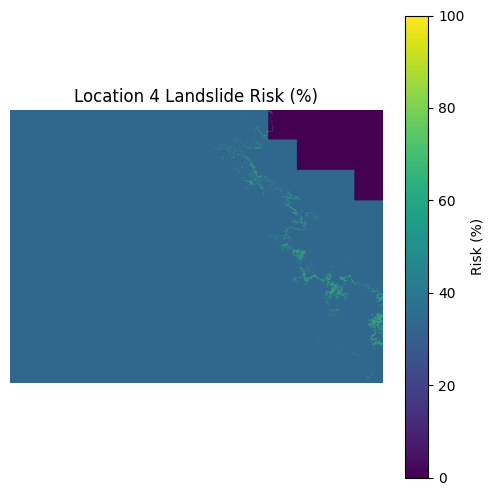

In [ ]:
import matplotlib.pyplot as plt
import rasterio

# Load the risk percentage map
with rasterio.open('location4_risk_pct.tif') as src:
    risk = src.read(1)
    plt.figure(figsize=(6,6))
    plt.imshow(risk, vmin=0, vmax=100)
    plt.colorbar(label='Risk (%)')
    plt.title('Location 4 Landslide Risk (%)')
    plt.axis('off')
    plt.show()

In [ ]:
import numpy as np
from shapely.geometry import Point
import pandas as pd
import rasterio

threshold = 67.0

with rasterio.open('location4_risk_pct.tif') as src:
    arr = src.read(1)
    transform = src.transform
    crs = src.crs

# Find pixel indices above threshold
rows, cols = np.where(arr >= threshold)

# Convert to lon/lat
xs, ys = rasterio.transform.xy(transform, rows, cols)
risks = arr[rows, cols]

# Build a DataFrame
df = pd.DataFrame({
    'lon': xs,
    'lat': ys,
    'risk_pct': risks
})

# Save to CSV
df.to_csv('location4_high_risk_points.csv', index=False)
print("Saved high-risk points (>=67%) to location4_high_risk_points.csv")

Saved high-risk points (>=67%) to location4_high_risk_points.csv


In [ ]:
!pip install simplekml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65860 sha256=1c97ec39923ebdfcb01f98b1dc2b8446be88ea67241a6b134aa49a50a00ff5de
  Stored in directory: /root/.cache/pip/wheels/72/3e/80/c3e5c354c3cbe62d8c5e4fb63d9e7cdccc7f93399997ae465f
Successfully built simplekml


In [ ]:
import simplekml

kml = simplekml.Kml()
for idx, row in df.iterrows():
    kml.newpoint(
        name=f"{row.risk_pct:.0f}%",
        coords=[(row.lon, row.lat)]
    )
kml.save('location4_high_risk.kml')
print("Saved KML to location4_high_risk.kml")

Saved KML to location4_high_risk.kml


In [ ]:
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape

with rasterio.open('location4_risk_pct.tif') as src:
    mask = src.read(1) >= 67   # e.g. two‐criteria threshold
    transform = src.transform

geoms = []
for geom, val in shapes(mask.astype('uint8'), mask=mask, transform=transform):
    if val == 1:
        geoms.append(shape(geom))

gdf = gpd.GeoDataFrame(geometry=geoms, crs=src.crs)
gdf.to_file('location4_risk_zones.shp')

In [ ]:
# once more

In [7]:
import glob
import numpy as np
import pandas as pd
import rasterio

# 1) Load the aligned velocity and slope rasters
with rasterio.open('/content/drive/MyDrive/mintpy_output/location4/velocity_aligned_L4.tif') as src:
    vel = src.read(1)            # m/yr
    transform = src.transform
    crs = src.crs
    height = src.height
    width = src.width

with rasterio.open('/content/drive/MyDrive/mintpy_output/location4/slope_L4.tif') as src:
    slope = src.read(1)          # degrees

# 2) Build a stacked rainfall array (shape: 37 × H × W)
rain_files = sorted(glob.glob(
    '/content/drive/MyDrive/location4/location4_rainfall_tiffs/rainfall_*.tif'
))
rain_stack = np.stack([
    rasterio.open(f).read(1) for f in rain_files
], axis=0)  # (37, H, W)

# 3) Compute each flag
rain_flag   = (rain_stack > 75).any(axis=0)    # True where any 12-day window >75 mm

# UPDATED VELOCITY FLAG: threshold raised from 0.05 → 0.45 m/yr
vel_flag    = (vel > 0.45)                     # True where velocity >0.45 m/yr

slope_flag  = (slope > 30)                     # True where slope >30°

# 4) Compute risk score (0–3) and convert to percentage
risk_score  = rain_flag.astype(int) \
            + vel_flag.astype(int)   \
            + slope_flag.astype(int)

risk_pct = (risk_score / 3.0) * 100.0   # 0, 33.33..., 66.67..., 100
risk_pct = risk_pct.astype('float32')

# 5) Flatten arrays and compute lon/lat for every pixel
rows, cols = np.indices((height, width))    # shape (H, W)
lons, lats = rasterio.transform.xy(transform, rows, cols)

lons_flat       = np.array(lons).ravel()
lats_flat       = np.array(lats).ravel()
risk_flat       = risk_pct.ravel()
rain_flag_flat  = rain_flag.ravel().astype(int)
vel_flag_flat   = vel_flag.ravel().astype(int)
slope_flag_flat = slope_flag.ravel().astype(int)

# 6) Build a DataFrame
df_all = pd.DataFrame({
    'lon':        lons_flat,
    'lat':        lats_flat,
    'risk_pct':   risk_flat,
    'rain_flag':  rain_flag_flat,
    'vel_flag':   vel_flag_flat,   # now uses the 0.45 m/yr threshold
    'slope_flag': slope_flag_flat
})

# 7) Save to CSV
csv_path = 'location4_all_risk_points_updated.csv'
df_all.to_csv(csv_path, index=False)
print(f"Saved all pixel risk data (with 0.45 m/yr velocity threshold) to: {csv_path}")

Saved all pixel risk data (with 0.45 m/yr velocity threshold) to: location4_all_risk_points_updated.csv


In [10]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

# Path to your Wayanad landslide shapefile for Location 4
land_shp = '/content/drive/MyDrive/mintpy_output/location4/wayanad_landslide_shapefile.shp'

# Reference raster (aligned velocity) for geo‐info
ref_tif = '/content/drive/MyDrive/mintpy_output/location4/velocity_aligned_L4.tif'
with rasterio.open(ref_tif) as ref:
    meta = ref.meta.copy()
    height = ref.height
    width = ref.width
    transform = ref.transform
    crs = ref.crs

# 1) Load the shapefile
gdf = gpd.read_file(land_shp)

# 2) Prepare (geom, value) tuples: 1 = landslide
shapes = [(geom, 1) for geom in gdf.geometry]

# 3) Rasterize into a (height × width) array
labels = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,           # non‐landslide pixels = 0
    dtype='uint8'
)

# 4) Save as GeoTIFF
meta.update({
    'count': 1,
    'dtype': 'uint8'
})
out_label = 'ls_labels_L4.tif'
with rasterio.open(out_label, 'w', **meta) as dst:
    dst.write(labels, 1)

print(f"Rasterized labels saved to {out_label}.")

DataSourceError: Unable to open /content/drive/MyDrive/mintpy_output/location4/wayanad_landslide_shapefile.shx or /content/drive/MyDrive/mintpy_output/location4/wayanad_landslide_shapefile.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [12]:
import rasterio
import numpy as np

# 1) Path to your pre-made label GeoTIFF
label_tif = "/content/drive/MyDrive/mintpy_output/location4/ls_labels_L4.tif"

# 2) Read the label raster (1 = landslide, 0 = stable)
with rasterio.open(label_tif) as src:
    label_arr = src.read(1).astype(np.uint8)
    label_meta = src.meta.copy()

print("Loaded label map:")
print("  Dimensions (H×W):", label_arr.shape)
print("  Unique label values:", np.unique(label_arr))

Loaded label map:
  Dimensions (H×W): (269, 250)
  Unique label values: [0 1]


In [14]:
import glob
import numpy as np
import rasterio

# 1) List of static feature file paths (in this exact order):
feature_files = [
    "/content/drive/MyDrive/mintpy_output/location4/velocity_aligned_L4.tif",
    "/content/drive/MyDrive/mintpy_output/location4/trend_L4.tif",
    "/content/drive/MyDrive/mintpy_output/location4/slope_L4.tif",
    "/content/drive/MyDrive/mintpy_output/location4/aspect_L4.tif"
]

# 2) Add all 37 rainfall maps (sorted lexicographically by filename)
rain_dir = "/content/drive/MyDrive/location4/location4_rainfall_tiffs"
rain_files = sorted(glob.glob(f"{rain_dir}/rainfall_*.tif"))
feature_files += rain_files  # now total = 41 features

print("Total feature files:", len(feature_files))  # Expect 41

# 3) Read the first feature to get dimensions & meta
with rasterio.open(feature_files[0]) as ref:
    H, W = ref.height, ref.width
    feat_meta = ref.meta.copy()

# 4) Initialize an empty stack: (H, W, N_features)
N_features = len(feature_files)
feat_stack = np.zeros((H, W, N_features), dtype=np.float32)

# 5) Loop through feature files and read into the stack
for idx, fpath in enumerate(feature_files):
    with rasterio.open(fpath) as src:
        arr = src.read(1).astype(np.float32)
        feat_stack[:, :, idx] = arr

print("Feature stack shape:", feat_stack.shape)  # (H, W, 41)

Total feature files: 41


ValueError: could not broadcast input array from shape (2843,3809) into shape (2605,3549)

In [15]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import glob

# Path to reference raster (velocity_aligned_L4.tif)
ref_path = "/content/drive/MyDrive/mintpy_output/location4/velocity_aligned_L4.tif"
aligned_dir = "/content/drive/MyDrive/mintpy_output/location4/rainfall_aligned_tiffs"
os.makedirs(aligned_dir, exist_ok=True)

# Load reference grid info
with rasterio.open(ref_path) as ref:
    dst_crs = ref.crs
    dst_transform = ref.transform
    dst_width = ref.width
    dst_height = ref.height

# Loop through rainfall GeoTIFFs and reproject them to match reference
rain_files = sorted(glob.glob("/content/drive/MyDrive/location4/location4_rainfall_tiffs/rainfall_*.tif"))

for src_path in rain_files:
    with rasterio.open(src_path) as src:
        src_data = src.read(1)
        src_meta = src.meta.copy()

        dst_array = np.zeros((dst_height, dst_width), dtype=np.float32)
        reproject(
            source=src_data,
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

        out_path = os.path.join(aligned_dir, os.path.basename(src_path))
        src_meta.update({
            'crs': dst_crs,
            'transform': dst_transform,
            'width': dst_width,
            'height': dst_height
        })

        with rasterio.open(out_path, 'w', **src_meta) as dst:
            dst.write(dst_array, 1)

print(f"✅ All rainfall rasters aligned and saved to:\n  {aligned_dir}")

✅ All rainfall rasters aligned and saved to:
  /content/drive/MyDrive/mintpy_output/location4/rainfall_aligned_tiffs
